# How to make use of Dask clusters for parallel computing
**A DeepESDL example notebook** 

This notebook shows how to use Dask clusters for paralleling of workflows. Parallelization is useful when running workflows that require more computing resources than are available locally (or here in your DeepESDL workspace). The methods presented in this notebook take care of setting up the cluster with a desired number of workers, installing the environment on the worker nodes, and performing the parallel computation. When a task is finished and you no longer need the resources, you shut down the cluster with a single line of code, and all resources are shut down.

If you are new to Dask, you can get an introduction [here](https://www.dask.org/get-started). Please also refer to the [DeepESDL documentation](https://earthsystemdatalab.net/guide/jupyterlab/) for further information!

Brockmann Consult, 2025

-----------------

**To run this notebook you need a python environment with:**
- python>=3.12
- xcube>=1.1.2
- coiled
- dask
- ipykernel

To create a custom environment, please refer to the [documentation](https://earthsystemdatalab.net/guide/jupyterlab/#creating-custom-team-python-environment).

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;">
<font size="+0.5">In order to work with the cluster service, the Dask processing cluster has to be added to your team from the <a href="https://portfolio.nor-discover.org/Service/Brockmann-DeepESDL/SponsoringWizardPricelist">NoR (Network of Resources) portal</a>. The example notebook will only run if your team has already access to the service and a suitable environment is selected.</font>
</div>

If your team has access, you have to execute the following line once in your terminal: 

`$ coiled login --account bc --token $COILED_TOKEN`
You just need to do this on the very first usage.

In case you encounter the error message: `bash: coiled: command not found`

Make sure to activate a suitable conda env in the terminal before, e.g.:  
`conda activate deepesdl-xcube-1.11.0`



In [2]:
from xcube.util.dask import new_cluster
from dask.distributed import Client
import os

In [3]:
# mandatory: Dask cluster service mirrors your currently selected environment and does not take the default environment
del os.environ['JUPYTER_IMAGE']

-------------------
#### Set up Dask cluster
Before starting a cluster, think about a good cluster name as well as how many workers you expect to need for your task. The cluster name is helpful in case your Jupyter notebook crashes or you wish to connect to a running cluster from another notebook. It will then recognize that a cluster with the indicated name is already running and connect to it. 

The following cell creates a cluster with two worker nodes using the default instance type (spot instances). For additional settings, please refer to the [xcube documentation](https://xcube.readthedocs.io/en/latest/api.html#xcube.util.dask.new_cluster).

Whenever you start a cluster, please make sure to shut it down with `cluster.shutdown()` once finished! Otherwise, your processing units will go unused. 

In [4]:
# default instance type selected contains 4 cores
cluster = new_cluster(name='team_computing_monthly_means', n_workers=2)


╭─────────────────────────────── Coiled Cluster ───────────────────────────────╮
│                   ]8;id=761826;https://cloud.coiled.io/clusters/1142522\https://cloud.coiled.io/clusters/1142522]8;;\                   │
╰──────────────────────────────────────────────────────────────────────────────╯
╭────────────── Overview ──────────────╮╭─────────── Configuration ────────────╮
│                                      ││                                      │
│ Name: team_computing_monthly_means   ││ Region: eu-central-1                 │
│                                      ││                                      │
│ Scheduler Status: started            ││ Scheduler: m6i.xlarge                │
│                                      ││                                      │
│ Dashboard:                           ││ Workers:   m5.xlarge (2)             │
│ ]8;id=277940;https://cluster-ynruo.dask.host?token=RuzIoi4C6K6g8q7C\https://cluster-ynruo.dask.host?toke]8;;\ ││                                      │
│ ]8;id=277940;https://cluster-ynruo.dask.host?token=RuzIoi4C6K6g8q7C\n=RuzIoi4C6K6g8q7C]8;;\                   ││ Workers Requested: 2                 │
│                                      ││                                      │
╰──────────────────────────────────────╯╰──────────────────────────────────────╯
╭───────────────────────── (2025/09/10 10:31:58 UTC) ──────────────────────────╮
│                                                                              │
│                              All workers ready.                              │
│                                                                              │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯

Connect your newly started cluster to the Dask client:

In [5]:
# check cluster status
cluster.status

<Status.running: 'running'>

In [6]:
client = Client(cluster)

To test the cluster, we will create monthly means for a variable from the Earth System Data Cube provided by DeepESDL. To get more inspiration, when Dask may be useful, check out the [example section](https://examples.dask.org/xarray.html).

---------------------
#### Access Data and create monthly means

In [7]:
from xcube.core.store import new_data_store
store = new_data_store("s3", root="deep-esdl-public")
store.list_data_ids()

['LC-1x2025x2025-2.0.0.levels',
 'LC-1x2160x2160-1.0.0.levels',
 'SMOS-L2C-OS-20230101-20231231-1W-res0-1x1000x1000.levels',
 'SMOS-L2C-OS-20230101-20231231-1W-res0-53x120x120.zarr',
 'SMOS-L2C-OS-20230101-20231231-1W-res0.zarr',
 'SMOS-L2C-SM-20230101-20231231-1W-res0-1x1000x1000.levels',
 'SMOS-L2C-SM-20230101-20231231-1W-res0-53x120x120.zarr',
 'SMOS-L2C-SM-20230101-20231231-1W-res0.zarr',
 'SMOS-freezethaw-1x720x720-1.0.1.zarr',
 'SMOS-freezethaw-4267x10x10-1.0.1.zarr',
 'SeasFireCube-8D-0.25deg-1x720x1440-3.0.0.zarr',
 'SeasFireCube-8D-0.25deg-966x180x360-3.0.0.zarr',
 'SeasFireCube_v3.zarr',
 'black-sea-1x1024x1024.levels',
 'black-sea-256x128x128.zarr',
 'cmems_sst_v2.zarr',
 'esa-cci-permafrost-1x1151x1641-0.0.2.levels',
 'esa-cci-permafrost-1x1151x1641-1.0.0.zarr',
 'esdc-8d-0.083deg-184x270x270-2.1.1.zarr',
 'esdc-8d-0.25deg-1x720x1440-3.0.1.zarr',
 'esdc-8d-0.25deg-256x128x128-3.0.1.zarr',
 'extrAIM-merged-cube-1x86x179.zarr',
 'hydrology-1D-0.009deg-100x60x60-3.0.2.zarr',
 

We select a cube, that contains 256 timestamps in one chunk.

In [8]:
dataset = store.open_data('esdc-8d-0.25deg-256x128x128-3.0.1.zarr')
dataset

<xarray.Dataset> Size: 353GB
Dimensions:                            (time: 1978, lat: 720, lon: 1440)
Coordinates:
  * lat                                (lat) float64 6kB -89.88 -89.62 ... 89.88
  * lon                                (lon) float64 12kB -179.9 ... 179.9
  * time                               (time) datetime64[ns] 16kB 1979-01-05 ...
Data variables: (12/42)
    aerosol_optical_thickness_550      (time, lat, lon) float32 8GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    air_temperature_2m                 (time, lat, lon) float32 8GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    bare_soil_evaporation              (time, lat, lon) float32 8GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    burnt_area                         (time, lat, lon) float64 16GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    cot                                (time, lat, lon) float32 8GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    cth                                (time, lat, lon) float32 8GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    ...                                 ...
    sif_rtsif                          (time, lat, lon) float32 8GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    sm                                 (time, lat, lon) float32 8GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    snow_sublimation                   (time, lat, lon) float32 8GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    surface_moisture                   (time, lat, lon) float32 8GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    terrestrial_ecosystem_respiration  (time, lat, lon) float32 8GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
    transpiration                      (time, lat, lon) float32 8GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

Select a variable, for which you would like to calculate monthly means. In this example, we select air_temperature_2m.

In [9]:
air_dataset = dataset[['air_temperature_2m']]
air_dataset

<xarray.Dataset> Size: 8GB
Dimensions:             (time: 1978, lat: 720, lon: 1440)
Coordinates:
  * lat                 (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                 (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                (time) datetime64[ns] 16kB 1979-01-05 ... 2021-12-31
Data variables:
    air_temperature_2m  (time, lat, lon) float32 8GB dask.array<chunksize=(256, 128, 128), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

Next, we will specify how to resample the dataset. It is important to note that this is a **lazy** operation. After executing the next cell, the ```air_dataset_monthly``` should only contain one value for each month in its metadata and structure, even though the data has **not** yet been resampled.

In [10]:
air_dataset_monthly = air_dataset.resample({'time':'1ME'}).mean()
air_dataset_monthly

<xarray.Dataset> Size: 2GB
Dimensions:             (time: 516, lat: 720, lon: 1440)
Coordinates:
  * lat                 (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                 (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                (time) datetime64[ns] 4kB 1979-01-31 ... 2021-12-31
Data variables:
    air_temperature_2m  (time, lat, lon) float32 2GB dask.array<chunksize=(67, 128, 128), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

Next, in order to use the data for further analysis, the monthly resampling needs to be run. 
The following command will take some time.

In [11]:
computed_air_dataset_monthly = air_dataset_monthly.compute()


In [12]:
computed_air_dataset_monthly

<xarray.Dataset> Size: 2GB
Dimensions:             (time: 516, lat: 720, lon: 1440)
Coordinates:
  * lat                 (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                 (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                (time) datetime64[ns] 4kB 1979-01-31 ... 2021-12-31
Data variables:
    air_temperature_2m  (time, lat, lon) float32 2GB -30.6 -30.6 ... -23.28
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

----------------------
### Shut down Dask cluster

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;">
<font size="+0.5">
Once you are finished with your computations, make sure to shutdown the cluster so your quoata of  available CPU hours is not used for an idle cluster.</font>
</div>

In [15]:
cluster.shutdown()

Note, resampling by month, will always put the date for the month on the last day of the month per default.

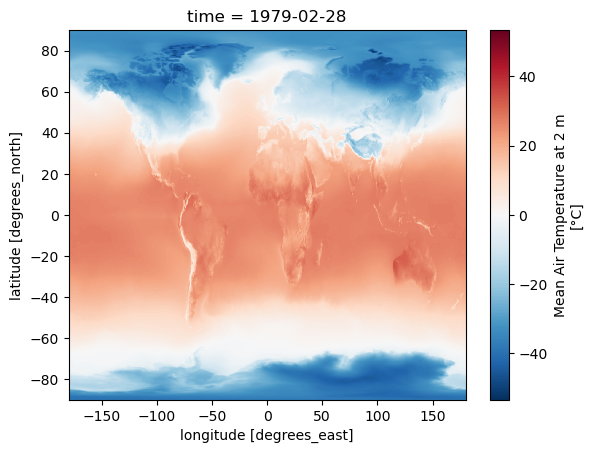

In [16]:
computed_air_dataset_monthly.air_temperature_2m.isel(time=1).plot.imshow()

If you wish to persist the dataset to your team storage, please checkout the example notebook Team Storage "SAVE CUBE TO TEAM STORAGE".